In [62]:
#Import libraries
# feature extractoring and preprocessing data
%matplotlib inline
import os
import pathlib
import csv
import cv2
import librosa
import librosa.display
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
import IPython.display as ipd

#Keras and Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,scale
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc

import warnings
warnings.filterwarnings('ignore')

# DATASET

Let's see what's in the 2 datasets. 

As we can see. The metadata for Aicovid 115M dataset have file_path, gende, age and I am not gonna use them. The assessment_result (0: negative, 1:positive)

In [63]:
metadata_train_challenge = pd.read_csv('../input/aicovidvn115m/aicv115m_public_train/aicv115m_public_train/metadata_train_challenge.csv')
print('len metadata_train_challenge',len(metadata_train_challenge.iloc[:,-1]))
metadata_train_challenge.head(4)

len metadata_train_challenge 1199


,uuid,subject_gender,subject_age,assessment_result,file_path
0,3284bcf1-2446-4f3a-ac66-14c76b294177,male,23.0,0,3284bcf1-2446-4f3a-ac66-14c76b294177.wav
1,431334e1-5946-4576-bb51-8e342ccc22b4,NaN,NaN,0,431334e1-5946-4576-bb51-8e342ccc22b4.wav
2,1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1,NaN,NaN,0,1d6fac4b-1e7f-4bdc-81cd-3a720bfbb1e1.wav
3,c7ee0695-b2e7-4beb-b904-f1455c9609d9,male,49.0,0,c7ee0695-b2e7-4beb-b904-f1455c9609d9.wav


In the file cough_trial_extended.csv have sowm information that the author have done before. 

In [64]:
cough_trial_extended = pd.read_csv('../input/coughclassifier-trial/cough_trial_extended.csv')
print('len cough_trial_extended',len(cough_trial_extended.iloc[:,-1]))
cough_trial_extended.head(4)

len cough_trial_extended 170


,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid


The ideal is to combine the 2 data into 1 csv file with 2 column, The first one is the file path and the second one is encoded labels (0: negative, 1:positive)

In [65]:
header = 'filePath label'
header = header.split()

file = open('data_file_Path.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
data =[]
for i,label in enumerate(cough_trial_extended['class']):
    if label =='not_covid':
        label = '0'
    else:
        label = '1'
    filename = cough_trial_extended.iloc[i ,0]
    filePath = '../input/coughclassifier-trial/trial_covid/' + str(filename)
    data = [filePath, label]
    file = open('data_file_Path.csv', 'a')
    with file:
        writer = csv.writer(file)
        writer.writerow(data)


In [66]:
data =[]
for i,label in enumerate(metadata_train_challenge['assessment_result']):
    filename = metadata_train_challenge.iloc[i ,-1]
    filePath = '../input/aicovidvn115m/aicv115m_public_train/aicv115m_public_train/train_audio_files_8k/train_audio_files_8k/' + str(filename)
    data = [filePath, label]
    file = open('data_file_Path.csv', 'a')
    with file:
        writer = csv.writer(file)
        writer.writerow(data)
data = pd.read_csv('./data_file_Path.csv')
print ('len data', len(data.iloc[:,1]))
data.head(8)    

len data 1369


,filePath,label
0,../input/coughclassifier-trial/trial_covid/0v8...,0
1,../input/coughclassifier-trial/trial_covid/1j1...,0
2,../input/coughclassifier-trial/trial_covid/1MS...,0
3,../input/coughclassifier-trial/trial_covid/1Pa...,0
4,../input/coughclassifier-trial/trial_covid/cov...,1
5,../input/coughclassifier-trial/trial_covid/cov...,1
6,../input/coughclassifier-trial/trial_covid/cou...,1
7,../input/coughclassifier-trial/trial_covid/pos...,1


#PREPROCESSING
#We will extract 2D features like:
* Mel-frequency Spectrogram
* chroma

#And then combine them into image to feed into the model. Also extract these features and mean them through time:
* MFCCs
* Spectral Centroid
* Spectral Bandwidth
* Spectral Roll-off
* ZCR + energy


In [67]:
Features = []
Number = len(data.iloc[:,1]) #Number of files I want to try on Number = len(data.iloc[:,1]) for all data
for file in data['filePath'][:Number]:

    y,sr=librosa.load(file)
    if librosa.get_duration(y=y, sr=sr) > 30:
        y,sr=librosa.load(file, duration = 30)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, S=None, n_fft=2048, 
                                              hop_length=512, win_length=None, window='hann', 
                                              center=True, pad_mode='reflect', power=2.0)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, S=None, norm=None, n_fft=2048, 
                                hop_length=512, win_length=None, window='hann', 
                                center=True, pad_mode='reflect', tuning=None, n_chroma=12)
    MFCC = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)
    
    ZCR = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512, center=True)
    
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, S=None, n_fft=2048, 
                                      hop_length=512, freq=None, win_length=None, window='hann', 
                                                          center=True, pad_mode='reflect')
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, S=None, n_fft=2048, 
                                       hop_length=512, win_length=None, window='hann', 
                                       center=True, pad_mode='reflect', freq=None, centroid=None, norm=True, p=2)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, S=None, n_fft=2048, 
                                     hop_length=512, win_length=None, window='hann', 
                                     center=True, pad_mode='reflect', freq=None, roll_percent=0.85)
    feature = np.concatenate((mel_spec,chroma_stft,MFCC,ZCR,spectral_centroid,spectral_bandwidth,spectral_rolloff), 
                             axis=0)
    feature = librosa.power_to_db(feature, ref=np.max)
    Features.append(feature)
    #print ('feature',feature.shape)
print ('Features',len(Features) )

Features 1369


**Visualize Data**

convert these images into dB value to have a better view on the problem. You can concatenate features with the vertical axis. It helps retain the time information. From there, our CRNN can work better

Some information need to be used on time axis to work well like Mel-spectrogram, MFCC or ZCR/energy. In fact, they usually combine ZCR/Energy to distinguish when it is sound and when it is not. When there is sound ZCR will suddenly decrease and energy suddenly rise at the same time

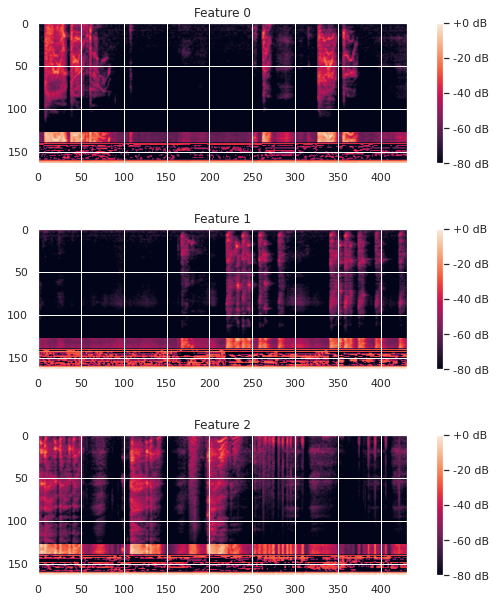

In [68]:
plt.figure(num='Features',figsize=(9,9))
for i, img in enumerate(Features[:3]):
    plt.subplot(3,1,i+1) 
    plt.title('Feature {}'.format(i))
    #S_dB = librosa.power_to_db(img, ref=np.max)
    #img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)        
    plt.imshow(img)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout(pad=3.0)
    #plt.axis('off')    
plt.show()

# PREPARE FOR TRAINING

This part is for displaying the length of data.

the majority of the files are around 15 seconds long. Only two files are longer than that. I'm going to shorten that file to 30 seconds. 

max_length 1292


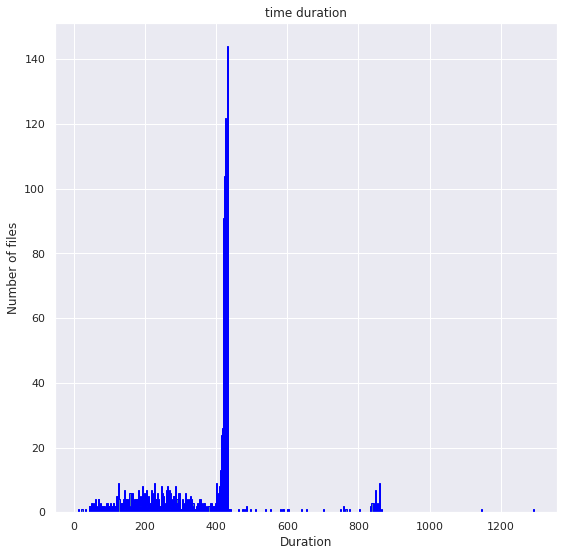

In [70]:
Time = np.array([x.shape[1] for x in Features])
unique, counts = np.unique(Time, return_counts=True)
#print (dict(zip(unique, counts)))
max_length = np.max(Time)
print ('max_length',max_length)

width = 3  # the width of the bars
plt.figure(num='Time',figsize=(9,9))
plt.xlabel('Duration')
plt.ylabel('Number of files')

plt.title('time duration')
plt.bar(unique,counts, width ,ec='blue')   
plt.show()

Sorted padding with Batch
because it's much more simple and faster

Cause the original file is so big, so I set newSize into a quarter of original size. The file length would be padding as the longest file

In [71]:

def preprocess(feature, featureSize):

    widthTarget, heightTarget = featureSize 
    height, width = feature.shape 

    # scale according to factor
    newSize = (int(width / 4),41) 
    #print ('newSize ={}, old size = {}'.format(newSize, feature.shape ))
    feature = cv2.resize(feature, newSize)
    # Normalization
    feature = scaler.fit_transform(feature)
    feature = np.pad(feature, ((0, 0), (0, widthTarget - feature.shape[1])), 'constant')
    #transpose
    feature = np.transpose(feature)
    
    return feature

We'll scale data and encode label

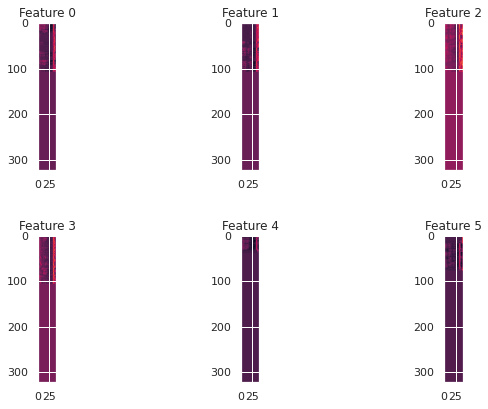

In [72]:
scaler = StandardScaler()
#print ('raw Features', Features[1])
scale_features =[]
for feature in Features[:Number]:
    feature = preprocess(feature,featureSize = (int(max_length/4),41)) #41 = 164/4
    scale_features.append(feature)

#print ('scale feature',scale_features[1])    
plt.figure(num='Features transpose',figsize=(9,9))

for i, img in enumerate(scale_features[:6]):
    plt.subplot(3,3,i+1) 
    plt.tight_layout(pad=3.0)
    plt.title('Feature {}'.format(i))
    plt.imshow(img)
    #plt.axis('off')    
plt.show()

In [73]:
genre_list = data.iloc[:Number, -1]
#print ('genre_list\n',genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list) #Gán nhãn 0,1 cho class. Có thể nói là đưa về one hot coding
neg, pos = np.bincount(y)
total = neg + pos
print ('positive: {} ({:.2f}% of total) \nnegative cases: {}'.format(pos, 100 * pos/total ,neg))

positive: 481 (35.14% of total) 
negative cases: 888


Now we will pad the files

# Dividing data into TRAINING, VALIDATION and TEST set

I will save the indices for the Data Augmentation stage

In [74]:
scale_features = np.array(scale_features).reshape(-1, int(max_length/4), 41, 1)
indices = range(len(scale_features))

In [75]:
x_train, x_test, y_train, y_test, indices_train,indices_test = train_test_split(scale_features, y, indices, test_size=0.15, shuffle = True, 
                                                    random_state = None, stratify = y)

X_train, X_valid, Y_train, Y_valid,Indices_train,Indices_valid = train_test_split(x_train, y_train,indices_train, test_size=0.2, shuffle = True, 
                                                    random_state = None, stratify = y_train )

Y_train = np_utils.to_categorical(Y_train, 2)
Y_valid = np_utils.to_categorical(Y_valid, 2)
print (len(Y_valid))

233


In [76]:
print ('\nlen(X_train)',len(X_train))
print ('len(X_valid)',len(X_valid))
print ('\n X_train.shape',X_train.shape)
print ('\n X_valid.shape',X_valid.shape)


len(X_train) 930
len(X_valid) 233

 X_train.shape (930, 323, 41, 1)

 X_valid.shape (233, 323, 41, 1)


# BUILDING MODEL

CRNN + attention due to it's power on time series data. The output will be flatten to classify 

In [77]:
def build_model(img_width = int(max_length/4),img_height = 41):
    # Inputs to the model

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    
    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2),strides = 2, name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), strides = 2, name="pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
  

    # Fourth conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

    x = layers.MaxPooling2D((1, 2), name="pool4")(x)

    # Fifth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_1")(x)
    

    # Sixth conv block
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_2")(x)

    x = layers.MaxPooling2D((1, 2), name="pool6")(x)

    # Seventh conv block
    x = layers.Conv2D(
        512,
        (2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="valid",
        name="Conv7",
    )(x)


    # The number of filters in the last layer is 512. Reshape accordingly before
    # passing the output to the RNN part of the model

    new_shape = (int(max_length/16)-1,512) 

    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    def attention_rnn(inputs):
        # inputs.shape = (batch_size, time_steps, input_dim)
        input_dim = int(inputs.shape[2])
        timestep = int(inputs.shape[1])
        a = layers.Permute((2, 1))(inputs) #Permutes the dimensions of the input according to a given pattern.
        a = layers.Dense(timestep, activation='softmax')(a) #// Alignment Model + Softmax
        a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)
        a_probs = layers.Permute((2, 1), name='attention_vec')(a)
        output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul') #// Weighted Average 
        return output_attention_mul

    x = attention_rnn(x)
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x  =layers.Flatten()(x)
    # Output layer
    
    x = layers.BatchNormalization(momentum = 0.8)(x)
    x = layers.Dense(512 , activation="sigmoid")(x)
    x = layers.Dense(256 , activation="sigmoid")(x) # 
    
    y_pred = layers.Dense(2 , activation="softmax", name="last_dense")(x) # y pred
    model = keras.models.Model(inputs=input_img, outputs=y_pred, name="model")
    
    return model
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 323, 41, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 323, 41, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 161, 20, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 161, 20, 128) 73856       pool1[0][0]                      
______________________________________________________________________________________________

# TRAINING

Epoch 1/55
30/30 [==============================] - 163s 5s/step - loss: 0.7684 - val_loss: 0.6718
Epoch 2/55
30/30 [==============================] - 150s 5s/step - loss: 0.6880 - val_loss: 0.6473
Epoch 3/55
30/30 [==============================] - 151s 5s/step - loss: 0.6539 - val_loss: 0.6520
Epoch 4/55
30/30 [==============================] - 151s 5s/step - loss: 0.6458 - val_loss: 0.6804
Epoch 5/55
30/30 [==============================] - 152s 5s/step - loss: 0.6430 - val_loss: 0.7108
Epoch 6/55
30/30 [==============================] - 151s 5s/step - loss: 0.6212 - val_loss: 0.6539
Epoch 7/55
30/30 [==============================] - 150s 5s/step - loss: 0.6520 - val_loss: 0.6607
Epoch 8/55
30/30 [==============================] - 150s 5s/step - loss: 0.6340 - val_loss: 0.6589
Epoch 9/55
30/30 [==============================] - 150s 5s/step - loss: 0.6286 - val_loss: 0.6754
Epoch 10/55
30/30 [==============================] - 151s 5s/step - loss: 0.6079 - val_loss: 0.6935
Epoch 11/

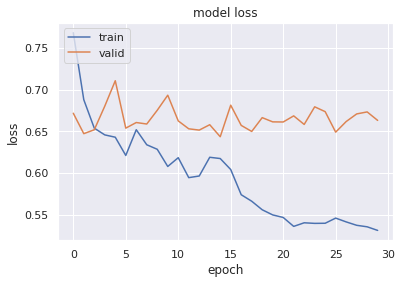

In [78]:
epochs = 55
batch_size = 32
early_stopping_patience = 15

def scheduler(epoch):
    if epoch <= 15:
        return 1e-3  
    elif 15 < epoch <=20:
        return 1e-4
    else:
        return 1e-5

# Add early stopping
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint(filepath='./covid_model/covid_model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 5),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]

model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy')                 

history = model.fit(x= X_train, y= Y_train, 
                validation_data=(X_valid, Y_valid),
                epochs = epochs, 
                batch_size = batch_size,
                callbacks = my_callbacks,
                )

# list all data in history
print(history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./covid_model/covid_model_loss.png')
plt.show()

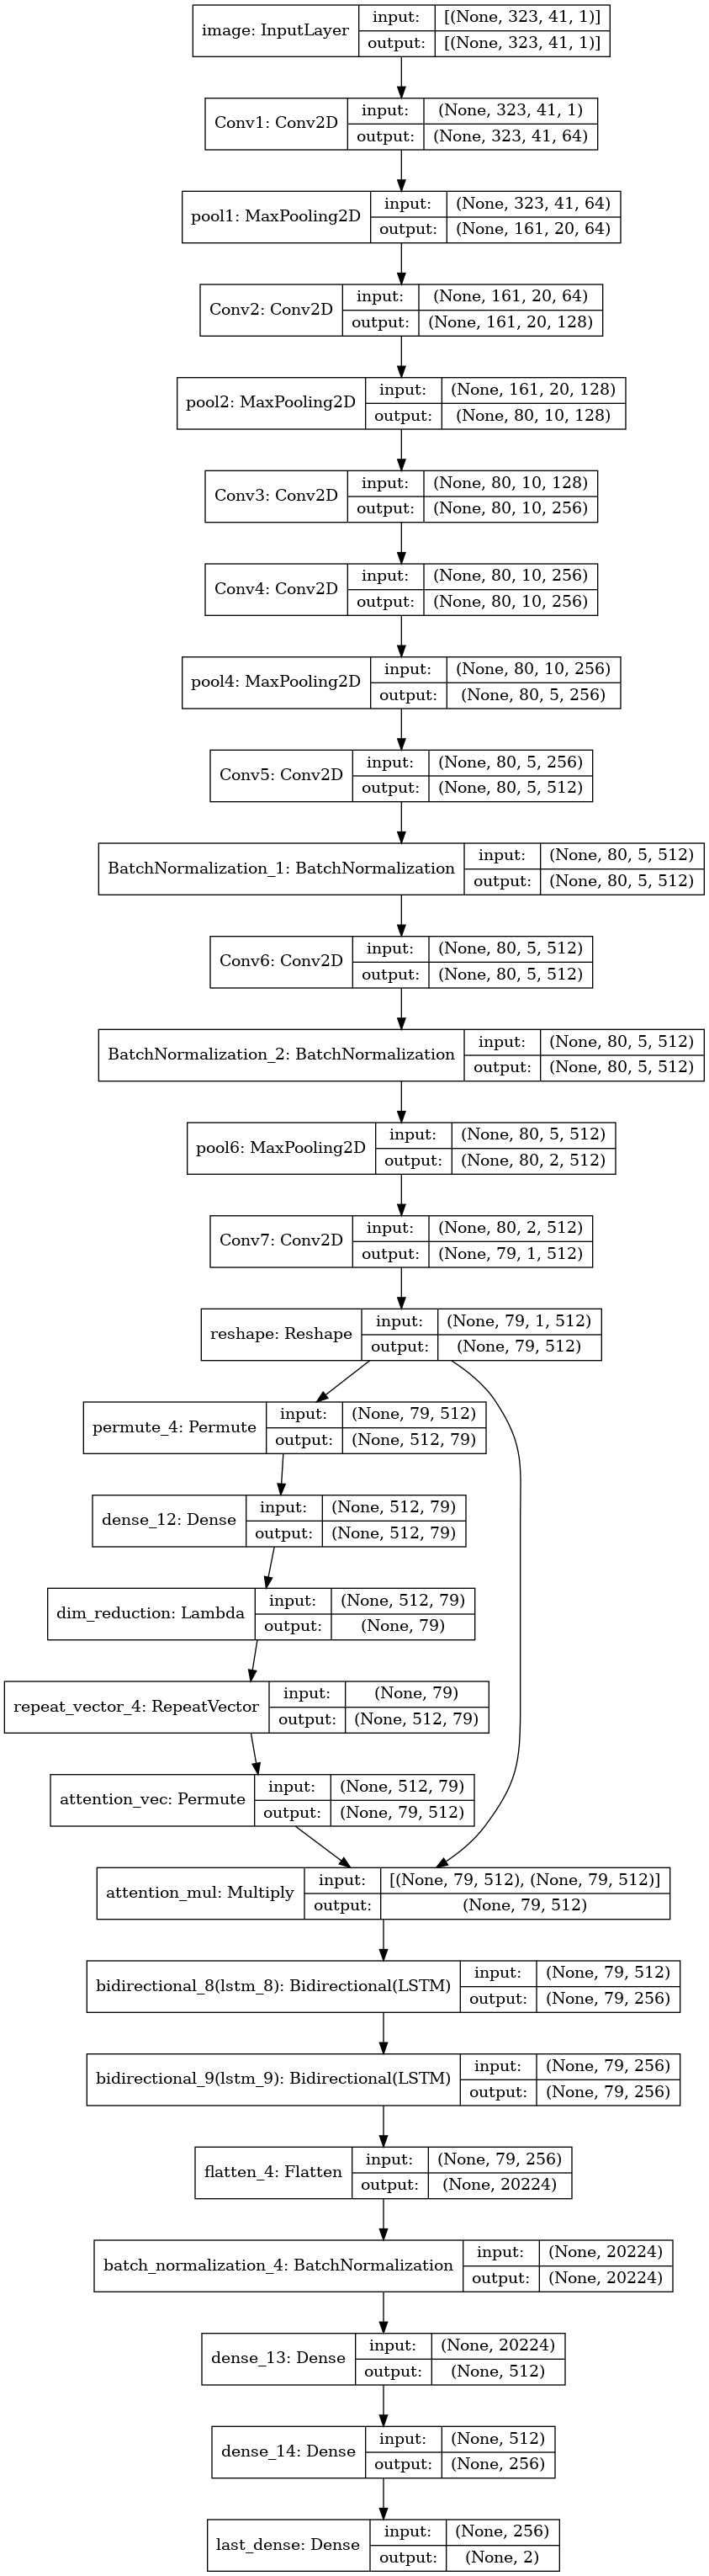

In [79]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# TESTING

I want to utilize the best model here, thus I loaded the best weights into the model. 

Choosing which output weights to use is based on the training history, and I have to change the path manualy all the time

In [80]:
load_model =0
load_model = build_model()
load_model.load_weights('./covid_model/covid_model_05.h5')

In [81]:
predictions = []
predictions = model.predict(x_test)
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)
print ('y_predict',y_predict)
print ('y test\n', y_test)

y_predict [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
y test
 [0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 

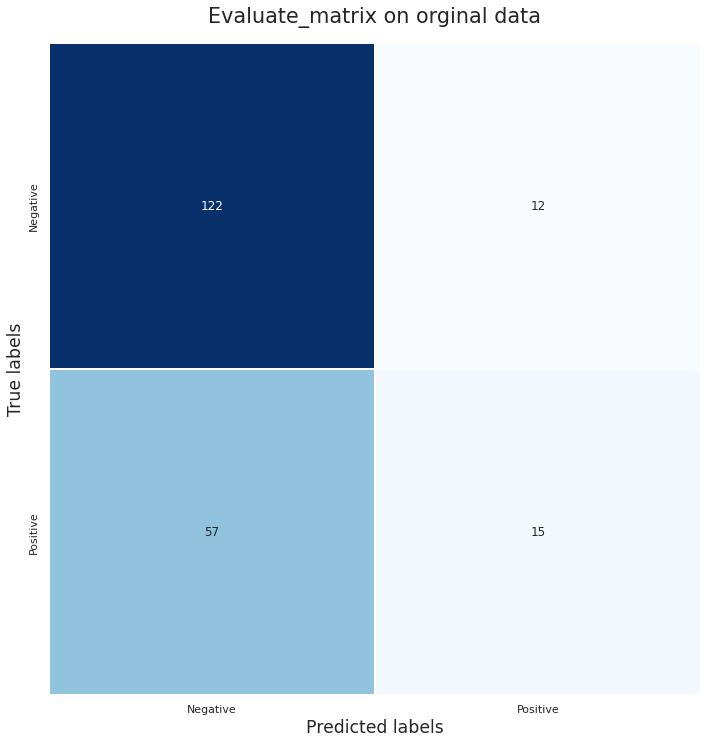

              precision    recall  f1-score   support

    Negative       0.68      0.91      0.78       134
    Positive       0.56      0.21      0.30        72

    accuracy                           0.67       206
   macro avg       0.62      0.56      0.54       206
weighted avg       0.64      0.67      0.61       206



In [82]:
import seaborn as sns
def evaluate_matrix(y_test, y_predict, name):
    cm = confusion_matrix(y_test, y_predict)
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])

    plt.figure(figsize=(10, 10))

    sns.set(font_scale=1)

    ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("True labels",fontsize = 'x-large')
    plt.xlabel("Predicted labels",fontsize = 'x-large')
    plt.tight_layout()
    plt.title(name,fontsize = 'xx-large',pad = 20)

    plt.show()

    print(classification_report(y_test, y_predict, target_names=["Negative", "Positive"]))
    
evaluate_matrix(y_test, y_predict,'Evaluate_matrix on orginal data')

AUC = 0.600


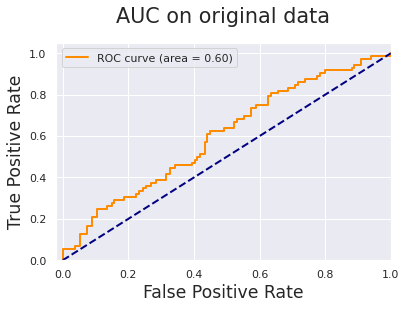

In [83]:
def ROC_curve(y_test,predictions,name):
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions[:,1])
    print ('AUC = {:.3f}'. format( auc(lr_fpr, lr_tpr)))
    # plot the roc curve for the model
    lw = 2
    plt.plot(lr_fpr, lr_tpr, color="darkorange",
             lw=lw, label="ROC curve (area = %0.2f)" % auc(lr_fpr, lr_tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    # axis labels
    pyplot.xlabel('False Positive Rate',fontsize = 'x-large')
    pyplot.ylabel('True Positive Rate',fontsize = 'x-large')
    plt.title(name,fontsize = 'xx-large', pad =20)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

ROC_curve(y_test,predictions,'AUC on original data')

# DATA AUGMENTATION
So the result above is quite bad and it can't be used in real life. I guess that Data Augmentation would help improve the outcome

Methods:
* Time Shift
* Adding background noise
* Stretching the sound (just a little bit)
* Changing Gain

I try not to generate fake sounds that rarely happen in real life, and distort the sound so much. So I don't recommend
* Time stretch (too much)
* Mix up 

Note: You have to use data augmentation on just the train and valid set

In [84]:
print ('indices_train',indices_train)  # This is the dataset that I used to split train, validation set
print ('y_train',y_train)

indices_train [98, 510, 506, 672, 1235, 1317, 1265, 839, 313, 555, 461, 528, 330, 784, 249, 507, 198, 707, 385, 789, 1080, 822, 244, 955, 1060, 1123, 1056, 325, 78, 115, 1154, 787, 797, 741, 355, 333, 1041, 828, 0, 55, 112, 837, 928, 466, 932, 259, 1336, 144, 1259, 798, 3, 496, 53, 17, 1192, 29, 703, 1302, 960, 1278, 515, 853, 265, 643, 1245, 392, 954, 805, 550, 712, 1350, 253, 718, 394, 445, 1106, 1352, 575, 586, 1037, 1193, 439, 194, 89, 895, 967, 352, 1010, 319, 1156, 27, 1129, 500, 1225, 1290, 1270, 1284, 835, 569, 192, 413, 736, 34, 705, 454, 69, 410, 1098, 572, 384, 125, 302, 1262, 1287, 1007, 1234, 708, 980, 166, 667, 574, 72, 492, 367, 923, 745, 165, 791, 870, 1171, 1048, 1029, 440, 1069, 1118, 216, 5, 952, 744, 403, 757, 365, 390, 547, 963, 958, 1220, 152, 1128, 593, 342, 520, 759, 685, 281, 427, 1043, 738, 58, 1086, 996, 45, 458, 488, 324, 570, 495, 107, 1170, 411, 1113, 1084, 6, 277, 1162, 269, 1211, 178, 616, 1349, 606, 43, 598, 869, 1025, 1348, 21, 938, 589, 1019, 1191, 65

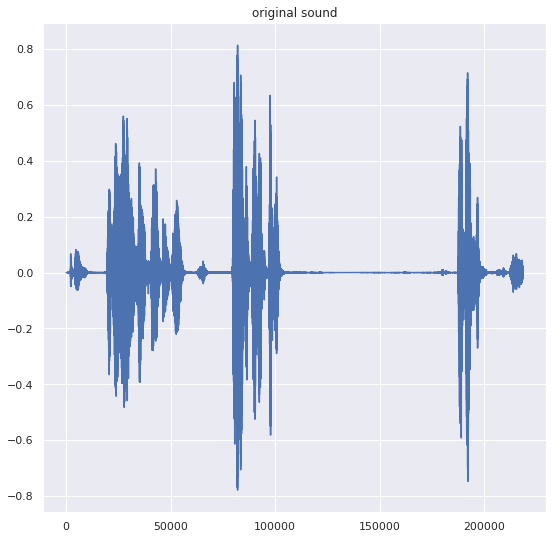

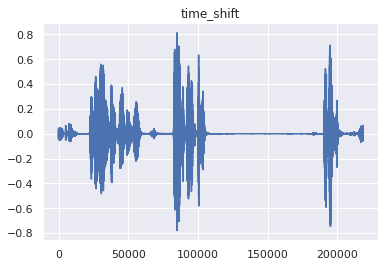

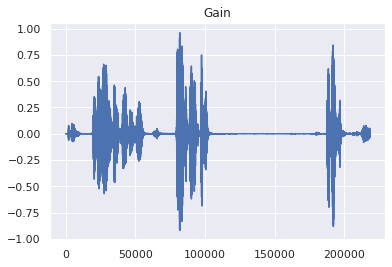

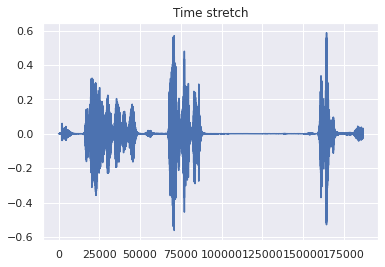

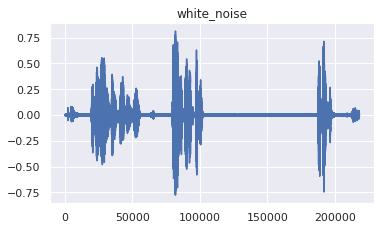

In [85]:
pos_indices = []
Aug_feature = []
for i,value in enumerate(y_train):
    if value == 1:
        pos_indices.append(indices_train[i])  
        
y, sr = librosa.load(data['filePath'][pos_indices[1]])        

def white_noise(y):
    wn = np.random.randn(len(y))
    y_wn = y + random.uniform(0, 0.005)*wn
    return y_wn

def time_shift(y):
    y = np.roll(y, random.randint(-10000,10000))
    return y

def Gain(y):
    y = y + random.uniform(-0.2,0.2)*y
    return y       
                            
def stretch(y, rate=random.uniform(0.8,1.2)):
    y = librosa.effects.time_stretch(y, rate)
    return y

plt.figure(num='Data Augmentation',figsize=(9,9))

plt.title ('original sound')
plt.plot(y) 
plt.show()

plt.title ('time_shift')
plt.plot(time_shift(y))
plt.show()

plt.title ('Gain')
plt.plot(Gain(y))
plt.show()

plt.title ('Time stretch')
plt.plot(stretch(y))
plt.show()

plt.title ('white_noise')
plt.plot(white_noise(y))

plt.tight_layout(pad=3.0)
#plt.axis('off')    
plt.show()

You can listen to these file to point out the diferences

In [86]:
print ('white noise')
ipd.Audio(white_noise(y), rate=sr)

white noise


In [87]:
print ('time shift')
ipd.Audio(time_shift(y), rate=sr)

time shift


In [88]:
print ('Gain')
ipd.Audio(Gain(y), rate=sr)

Gain


In [89]:
print ('time stretch')
ipd.Audio(stretch(y),rate=sr)

time stretch


Due to the dataset imbalanced problems as the result above
> positive: 481 (35.14% of total) 
> negative cases: 888

need to generate more positive cases more

In [90]:
num_aug = (neg - pos)/1.5
if num_aug > len(pos_indices):
    iteration = int(num_aug/len(pos_indices))
else:
    iteration =1
print ('Number of file generated based on one positive case',iteration)

for file in data['filePath'][pos_indices]:
    if librosa.get_duration(y=y, sr=sr) > 30:
        y,sr=librosa.load(file, duration = 30)
    for i in range (iteration):
        y,sr=librosa.load(file)
        
        chance = random.randint(0,100)
        if chance <=20:
            stretch(y)
        if chance <=40:
            time_shift(y)
        if chance <=60:
            Gain(y)
        if chance <=80:
            white_noise(y)

        ZCR = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512, center=True)
        if ZCR.shape[1] >= max_length:
            continue
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, S=None, n_fft=2048, 
                                                  hop_length=512, win_length=None, window='hann', 
                                                  center=True, pad_mode='reflect', power=2.0)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, S=None, norm=None, n_fft=2048, 
                                    hop_length=512, win_length=None, window='hann', 
                                    center=True, pad_mode='reflect', tuning=None, n_chroma=12)
        MFCC = librosa.feature.mfcc(y=y, sr=sr, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0)


        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, S=None, n_fft=2048, 
                                          hop_length=512, freq=None, win_length=None, window='hann', 
                                                              center=True, pad_mode='reflect')

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, S=None, n_fft=2048, 
                                           hop_length=512, win_length=None, window='hann', 
                                           center=True, pad_mode='reflect', freq=None, centroid=None, norm=True, p=2)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, S=None, n_fft=2048, 
                                         hop_length=512, win_length=None, window='hann', 
                                         center=True, pad_mode='reflect', freq=None, roll_percent=0.85)
        aug_feature = np.concatenate((mel_spec,chroma_stft,MFCC,ZCR,spectral_centroid,spectral_bandwidth,spectral_rolloff), 
                                 axis=0)
        aug_feature = librosa.power_to_db(aug_feature, ref=np.max)
        Aug_feature.append(aug_feature)
    #print ('Aug_feature',Aug_feature.shape)
print ('Aug_feature',len(Aug_feature) )        

Number of file generated based on one positive case 1
Aug_feature 409


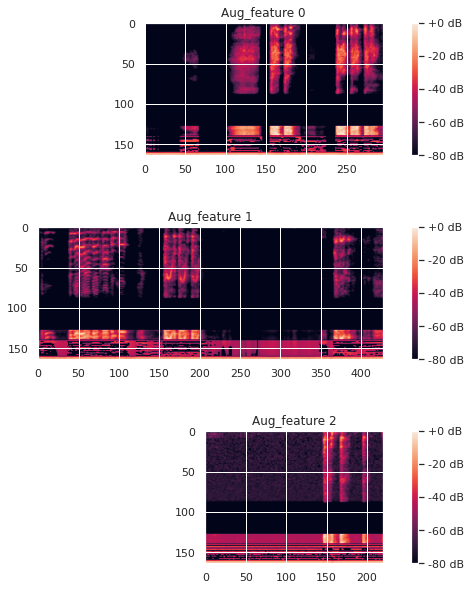

In [91]:
plt.figure(num='Aug_feature',figsize=(9,9))
for i, img in enumerate(Aug_feature[:3]):
    plt.subplot(3,1,i+1) 
    plt.title('Aug_feature {}'.format(i))      
    plt.imshow(img)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout(pad=3.0)
    #plt.axis('off')    
plt.show()

In [92]:
y_aug = np.ones((1,len(Aug_feature)),dtype = np.uint8)[0]
print (y_aug)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


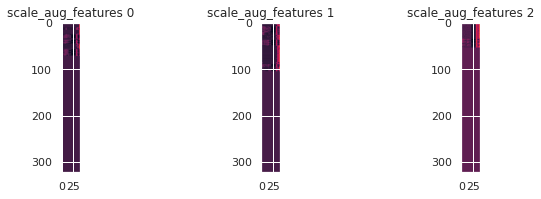

In [93]:
scale_aug_features =[]
for feature in Aug_feature:
    feature = preprocess(feature,featureSize = (int(max_length/4),41)) #41 = 164/4
    scale_aug_features.append(feature)

#print ('scale feature',scale_features[1])    
plt.figure(num='Features transpose',figsize=(9,9))

for i, img in enumerate(scale_aug_features[:3]):
    plt.subplot(3,3,i+1) 
    plt.tight_layout(pad=3.0)
    plt.title('scale_aug_features {}'.format(i))
    plt.imshow(img)
    #plt.axis('off')    
plt.show()

I'll combine augmented data with x_train data, then divide it into train and valid sets.

In [94]:
scale_aug_features = np.array(scale_aug_features).reshape(-1, int(max_length/4), 41, 1)
x_train = np.concatenate((x_train,scale_aug_features), axis=0)
print (len(x_train))

1572


In [95]:
y_train = np.concatenate((y_train,y_aug), axis=0)

In [96]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle = True,random_state = None, stratify = y_train )

Y_train = np_utils.to_categorical(Y_train, 2)
Y_valid = np_utils.to_categorical(Y_valid, 2)
#print (Y_valid)
print (len(Y_valid))
print('X_train.shape',X_train.shape)
print('X_valid.shape',X_valid.shape)

315
X_train.shape (1257, 323, 41, 1)
X_valid.shape (315, 323, 41, 1)


In [97]:
new_model = 0
new_model = build_model()

In [ ]:
my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint(filepath='./covid_model/new_covid_model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 5),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]

new_model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy')                 

new_history = new_model.fit(x= X_train, y= Y_train, 
                validation_data=(X_valid, Y_valid),
                epochs = epochs, 
                batch_size = batch_size,
                callbacks = my_callbacks,
                )

# list all data in history
print(new_history.history.keys())

# summarize history for loss

fig, ax = plt.subplots()
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./covid_model/new_covid_model_loss.png')
plt.show()

Epoch 1/55
40/40 [==============================] - 217s 5s/step - loss: 0.8001 - val_loss: 0.7270
Epoch 2/55
40/40 [==============================] - 203s 5s/step - loss: 0.7148 - val_loss: 0.7041
Epoch 3/55
40/40 [==============================] - 204s 5s/step - loss: 0.6751 - val_loss: 0.6446
Epoch 4/55
40/40 [==============================] - 202s 5s/step - loss: 0.6850 - val_loss: 0.6482
Epoch 5/55
40/40 [==============================] - 202s 5s/step - loss: 0.6909 - val_loss: 0.6919
Epoch 6/55
40/40 [==============================] - 204s 5s/step - loss: 0.6716 - val_loss: 0.6346
Epoch 7/55
40/40 [==============================] - 203s 5s/step - loss: 0.6536 - val_loss: 0.7105
Epoch 8/55
40/40 [==============================] - 203s 5s/step - loss: 0.6380 - val_loss: 0.6095
Epoch 9/55
40/40 [==============================] - 205s 5s/step - loss: 0.6366 - val_loss: 0.6507
Epoch 10/55
40/40 [==============================] - 206s 5s/step - loss: 0.6405 - val_loss: 0.6233
Epoch 11/

In [ ]:
new_load_model = 0
new_load_model = build_model()
new_load_model.load_weights('./covid_model/new_covid_model_10.h5')

In [ ]:
new_predictions = []
new_predictions = new_load_model.predict(x_test)
y_new_predict =[]
for i in range(len(new_predictions)):
    predict = np.argmax(new_predictions[i])
    y_new_predict.append(predict)
#print ('y_predict',y_predict)
#print ('y test\n', y_test)

In [ ]:
evaluate_matrix(y_test, y_new_predict,'Evaluate_matrix on Augmented data')
ROC_curve(y_test,new_predictions,'AUC on Augmented data')

In [ ]:
evaluate_matrix(y_test, y_predict,'Evaluate_matrix on Original data')
ROC_curve(y_test,predictions,'AUC on Original data')